In [7]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns
from IPython.display import display
pd.options.mode.chained_assignment = None
import matplotlib
matplotlib.style.use('ggplot')


#### Enter handler you want to read

In [55]:
handler = input().strip()
tweets = pd.read_csv('%s_tweets.csv' % handler, encoding = "ISO-8859-1")
tweets.head()

sayalidz


,Unnamed: 0,created_at,favorite_count,followers_count,friends_count,retweet_count,screen_name,text
0,0,2016-12-21 19:09:46,0,24,266,9,sayalidz,RT @analyticbridge: When Does Deep Learning Wo...
1,1,2016-12-17 06:21:32,0,24,266,4,sayalidz,RT @analyticbridge: 49 Machine Learning Resour...
2,2,2016-12-14 11:54:38,0,24,266,33,sayalidz,RT @KirkDBorne: BIG CheatSheet on #MachineLear...
3,3,2016-12-10 06:52:35,0,24,266,269,sayalidz,RT @AndrewYNg: Interested in Deep Reinforcemen...
4,4,2016-12-08 16:38:55,0,24,266,536,sayalidz,RT @pydatasci: The Python Data Science Handboo...


In [56]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [57]:
import re
#Preprocessing del RT @blablabla:
tweets['text_new'] = ''
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(':')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('RT @')[i]  == False:
        tweets['tweetos'][i] = 'other'

#'text_new' is the feature 'text' without the tweetos    
for i in range(len(tweets['text'])):
    m = re.search('(?<=:)(.*)', tweets['text'][i])
    if tweets['text'].str.contains('RT @')[i]  == True:
        try:
            tweets['text_new'][i]=m.group(0)
        except AttributeError:
            tweets['text_new'][i]=tweets['text'][i] 
    else:       
        tweets['text_new'][i] =  tweets['text'][i] 

In [62]:
RT = []
for t in tweets.text:
    RT.append(t.split()[0]=='RT')
tweets['RT'] = RT

In [58]:
tweets['tweetos'].head()

0    RT @analyticbridge
1    RT @analyticbridge
2        RT @KirkDBorne
3         RT @AndrewYNg
4         RT @pydatasci
Name: tweetos, dtype: object

In [59]:
tweets['text_new'].head()

0     When Does Deep Learning Work Better Than SVMs...
1     49 Machine Learning Resources and Related Art...
2     BIG CheatSheet on #MachineLearning #Algorithm...
3     Interested in Deep Reinforcement Learning? Gr...
4     The Python Data Science Handbook is now avail...
Name: text_new, dtype: object

In [63]:
tweets.dtypes

Unnamed: 0                  int64
created_at         datetime64[ns]
favorite_count              int64
followers_count             int64
friends_count               int64
retweet_count               int64
screen_name                object
text                       object
text_new                   object
tweetos                    object
RT                           bool
dtype: object

In [64]:
tweets['nb_words'] = 0
for i in range(len(tweets['text'])):
    tweets['nb_words'][i] = len(tweets['text'][i].split(' '))

In [70]:
tweets['hour'] = pd.DatetimeIndex(tweets['created_at']).hour
tweets['date'] = pd.DatetimeIndex(tweets['created_at']).date
tweets['minute'] = pd.DatetimeIndex(tweets['created_at']).minute
tweets.columns

Index(['Unnamed: 0', 'created_at', 'favorite_count', 'followers_count',
       'friends_count', 'retweet_count', 'screen_name', 'text', 'text_new',
       'tweetos', 'RT', 'nb_words', 'hour', 'date', 'minute'],
      dtype='object')

Check at which hour of day user is active ?

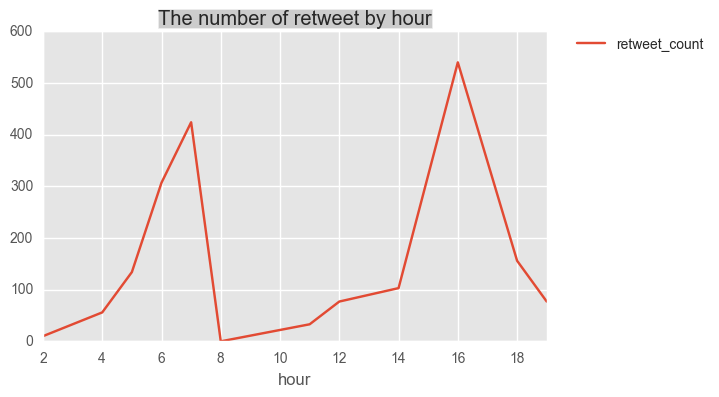

In [71]:
import seaborn as sns
tweets_hour = tweets.groupby(['hour'])['retweet_count'].sum()
tweets_hour.transpose().plot(kind='line',figsize=(6.5, 4))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('The number of retweet by hour', bbox={'facecolor':'0.8', 'pad':0})

In [72]:
def get_stop_words(s, n):

    from collections import Counter
    l = get_corpus(s)
    l = [x for x in Counter(l).most_common(n)]
    return l

def get_corpus(s):
    l = []
    s.map(lambda x: l.extend(x))
    return l

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text_new']]       
#vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
#X = vectorizer.fit_transform(tweets['text_lem'].str.upper())
#print(X.shape)
tweets.text_lem.head()

0    When Does Deep Learning Work Better Than SVMs ...
1    Machine Learning Resources and Related Article...
2    BIG CheatSheet on  MachineLearning  Algorithms...
3    Interested in Deep Reinforcement Learning  Gre...
4    The Python Data Science Handbook is now availa...
Name: text_lem, dtype: object

In [79]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

from nltk import tokenize

sid = SentimentIntensityAnalyzer()

tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
tweets.head()

,Unnamed: 0,created_at,favorite_count,followers_count,friends_count,retweet_count,screen_name,text,text_new,tweetos,...,nb_words,hour,date,minute,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,0,2016-12-21 19:09:46,0,24,266,9,sayalidz,RT @analyticbridge: When Does Deep Learning Wo...,When Does Deep Learning Work Better Than SVMs...,RT @analyticbridge,...,14,19,2016-12-21,9,When Does Deep Learning Work Better Than SVMs ...,0.4404,0.828,0.0,0.172,POSITIVE
1,1,2016-12-17 06:21:32,0,24,266,4,sayalidz,RT @analyticbridge: 49 Machine Learning Resour...,49 Machine Learning Resources and Related Art...,RT @analyticbridge,...,13,6,2016-12-17,21,Machine Learning Resources and Related Article...,0.2023,0.870,0.0,0.130,POSITIVE
2,2,2016-12-14 11:54:38,0,24,266,33,sayalidz,RT @KirkDBorne: BIG CheatSheet on #MachineLear...,BIG CheatSheet on #MachineLearning #Algorithm...,RT @KirkDBorne,...,17,11,2016-12-14,54,BIG CheatSheet on MachineLearning Algorithms...,0.0000,1.000,0.0,0.000,NEUTRAL
3,3,2016-12-10 06:52:35,0,24,266,269,sayalidz,RT @AndrewYNg: Interested in Deep Reinforcemen...,Interested in Deep Reinforcement Learning? Gr...,RT @AndrewYNg,...,16,6,2016-12-10,52,Interested in Deep Reinforcement Learning Gre...,0.7783,0.688,0.0,0.312,POSITIVE
4,4,2016-12-08 16:38:55,0,24,266,536,sayalidz,RT @pydatasci: The Python Data Science Handboo...,The Python Data Science Handbook is now avail...,RT @pydatasci,...,21,16,2016-12-08,38,The Python Data Science Handbook is now availa...,0.0000,1.000,0.0,0.000,NEUTRAL


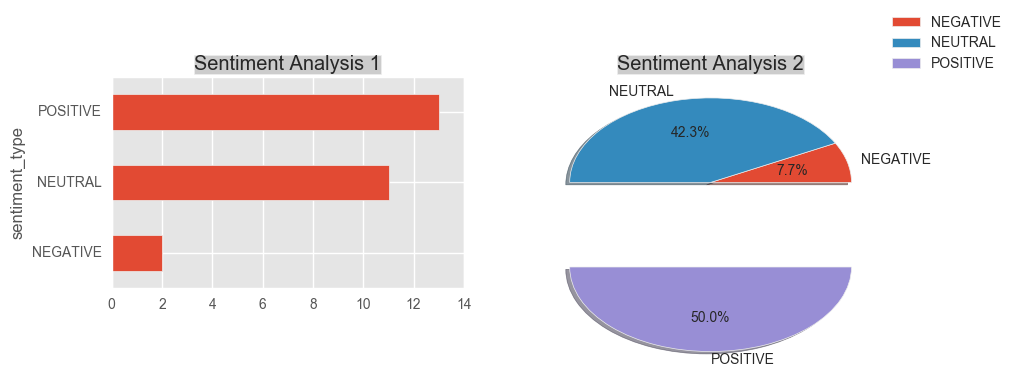

In [80]:
import matplotlib
matplotlib.style.use('ggplot')

tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (0, 0, 1.0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(10, 6))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(10, 6),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()